In [1]:
#!pip install torch==1.9.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.9.1+cpu torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torchaudio

In [21]:
#!pip install audtorch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import torch
import os
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import sklearn 

from IPython.display import clear_output
import tqdm.notebook as tqdm
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
from torch import nn
from sklearn.metrics import classification_report

import torch.nn.functional as F

#import audtorch
%matplotlib inline

In [53]:
from utils.dataloader import make_sorted_dataloader, collate_with_paddings
from utils.chunk_opensmile_dataset import ChunkOpenSmileDataSet
from utils.zip_dataset import ZippedDataSet, ConcatDataset
from utils.chunk_augmented_dataset import ChunkAugDataSet
from utils.scan_data import scan_rootdir
import utils.load_data
from utils.load_data import load_anno_tensor, load_vad_df


In [4]:
import opensmile

In [5]:
!ls data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/dev/029_2016-04-06_Nottingham

 annotation_expert.txt		  VAD_expert.annotation~
 annotation_novice.txt		  VAD_expert.annotation.xml
'expert.audio[48000]_clean.wav'   VAD_novice.annotation~
'novice.audio[48000]_clean.wav'   VAD_novice.annotation.xml


In [6]:
chunk_sz=6
DATA_BASEDIR="data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English"

In [7]:
d = ChunkOpenSmileDataSet(f'{DATA_BASEDIR}/dev', chunk_size_s=chunk_sz)
d[0]

675 chunks


{'feats': tensor([[2.0352e+00],
         [8.9619e-01],
         [3.4602e-02],
         ...,
         [4.5705e+01],
         [9.1253e+01],
         [5.6619e+01]]),
 'labels': tensor([0.0000, 0.3041, 0.6959, 0.0000, 0.0000]),
 'padding': tensor([1., 1., 1., 1., 1.]),
 'index': 0}

In [8]:
#train_ds = 
# chunk_sz=6
# DATA_BASEDIR="data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English"

# train_ds = ZippedDataSet(f'{DATA_BASEDIR}/train_opensmile_chunk{chunk_sz}s_msl0.zip', 
#                          ChunkOpenSmileDataSet(f'{DATA_BASEDIR}/train/', chunk_size_s=chunk_sz), 
#                          rewrite=False, 
#                          min_sample_len=0)
# dev_ds = ZippedDataSet(f'{DATA_BASEDIR}/dev_opensmile_chunk{chunk_sz}s_msl0.zip', 
#                         ChunkOpenSmileDataSet(f'{DATA_BASEDIR}/dev', chunk_size_s=chunk_sz), 
#                         rewrite=False, 
#                         min_sample_len=0)
# test_ds = ZippedDataSet(f'{DATA_BASEDIR}/test_opensmile_chunk{chunk_sz}s_msl0.zip', 
#                         ChunkOpenSmileDataSet(f'{DATA_BASEDIR}/test', chunk_size_s=chunk_sz), 
#                         rewrite=False, 
#                         min_sample_len=0)

Didn't find ANNO for data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/train/039_2016-04-07_Nottingham novice.
2320 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/train_opensmile_chunk6s_msl0.zip' exists! Using that archive
675 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/dev_opensmile_chunk6s_msl0.zip' exists! Using that archive
347 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/test_opensmile_chunk6s_msl0.zip' exists! Using that archive


In [54]:
DATA_BASEDIR="data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/"

data={}
for d in os.listdir(DATA_BASEDIR):
    print(d)
    data[d] = {}
    for subset in ['dev', 'test', 'train']:
        print(subset)
        subset_dir = DATA_BASEDIR + f'/{d}/{subset}'
        data[d][subset] = ZippedDataSet(f'{subset_dir}/opensmile_vad_chunk{chunk_sz}s_msl0.zip', 
                         ChunkOpenSmileDataSet(subset_dir, chunk_size_s=chunk_sz, use_vad=True), 
                         rewrite=False, 
                         min_sample_len=0)

English
dev
675 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//English/dev/opensmile_vad_chunk6s_msl0.zip' exists! Using that archive
test
347 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//English/test/opensmile_vad_chunk6s_msl0.zip' exists! Using that archive
train
Didn't find ANNO for data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//English/train/039_2016-04-07_Nottingham novice.
2320 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//English/train/opensmile_vad_chunk6s_msl0.zip' exists! Using that archive
German
dev
5275 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//German/dev/opensmile_vad_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (5275 -> 5275)


  0%|          | 0/5275 [00:00<?, ?it/s]

test
2268 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//German/test/opensmile_vad_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (2268 -> 2268)


  0%|          | 0/2268 [00:00<?, ?it/s]

train
Didn't find ANNO for data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//German/train/073_2016-05-23_Augsburg novice.
Didn't find ANNO for data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//German/train/067_2016-05-23_Augsburg expert.
12040 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//German/train/opensmile_vad_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (12040 -> 12040)


  0%|          | 0/12040 [00:00<?, ?it/s]

French
dev
9318 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//French/dev/opensmile_vad_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (9318 -> 9318)


  0%|          | 0/9318 [00:00<?, ?it/s]

test
4518 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//French/test/opensmile_vad_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (4518 -> 4518)


  0%|          | 0/4518 [00:00<?, ?it/s]

train
24759 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data//French/train/opensmile_vad_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (24759 -> 24759)


  0%|          | 0/24759 [00:00<?, ?it/s]

In [58]:
train_ds = ConcatDataset([d[l] for d in data.values() for l in ['train', 'test']])
dev_ds = ConcatDataset([d['dev'] for d in data.values()])
#test_ds = ConcatDataset([d['test'] for d in data.values()])

In [27]:
test_ds[0]['labels']

tensor([[0.0000, 0.0000, 0.3967, 0.5933, 0.0100]])

In [28]:
test_ds.feats_dim

AttributeError: 'ConcatDataset' object has no attribute 'feats_dim'

In [29]:
test_ds.anno_dim

AttributeError: 'ConcatDataset' object has no attribute 'anno_dim'

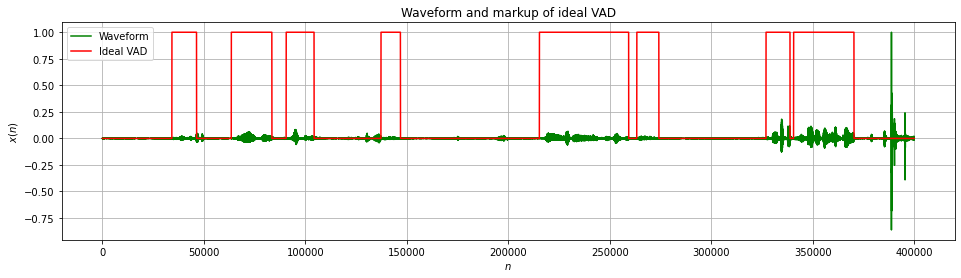

In [68]:

class DNNNet(nn.Module):                                                                                                                                                                 
    def __init__(self, num_cls=5, in_feats=6373):                                                                                                                                         
        super().__init__()
        self.bn = nn.BatchNorm1d(in_feats)
        self.layers = nn.Sequential(nn.Dropout(0.3),
                                nn.Linear(in_feats, 740), 
                                nn.Dropout(0.1),
                                nn.ReLU(),
                                    nn.Linear(740, 1024), 
                                nn.Dropout(0.3),
                                nn.ReLU(),
                                nn.Linear(1024, 740), 
                                nn.Dropout(0.1),
                                nn.ReLU(),
                                    nn.Linear(740, 1024), 
                                nn.Dropout(0.3),
                                nn.ReLU(),
                                nn.Linear(1024, 740), 
                                nn.Dropout(0.1),
                                nn.ReLU(),
                                    nn.Linear(740, 1024), 
                                nn.Dropout(0.3),
                                nn.ReLU(),
                                nn.Linear(1024, 740), 
                                nn.Dropout(0.1),
                                nn.ReLU(),
                                nn.Linear(740, num_cls))
            
        self.sf = torch.nn.LogSoftmax(dim=-1)
        
    def forward(self, x):
        x = x.squeeze(dim=-1)
        x = self.bn(x)
        x = self.layers(x)
        #x = self.sf(x)
        return x

In [69]:
DNNNet()

DNNNet(
  (bn): BatchNorm1d(6373, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=6373, out_features=740, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=740, out_features=1024, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=1024, out_features=740, bias=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): ReLU()
    (10): Linear(in_features=740, out_features=1024, bias=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=740, bias=True)
    (14): Dropout(p=0.1, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=740, out_features=1024, bias=True)
    (17): Dropout(p=0.3, inplace=False)
    (18): ReLU()
    (19): Linear(in_features=1024, out_features=740, bias=True)
    (20): Dropout(p=0.1, inplace=False)
    (21): ReLU()
 

In [70]:
def get_cls_weights(ds, num_classes=5):
    cls2num = torch.zeros(5)
    num=0
    for i in tqdm.tqdm(range(len(ds))):
        item = ds[i]
        cls2num += item['labels'].view(-1)
        num+=1
    return cls2num/num
print(f"Train labels distribution: {get_cls_weights(train_ds)}")
print(f"dev labels distribution: {get_cls_weights(dev_ds)}")
print(f"test labels distribution: {get_cls_weights(test_ds)}")

  0%|          | 0/46252 [00:00<?, ?it/s]

Train labels distribution: tensor([0.0144, 0.0980, 0.4210, 0.3848, 0.0818])


  0%|          | 0/15268 [00:00<?, ?it/s]

dev labels distribution: tensor([0.0050, 0.0458, 0.4092, 0.3262, 0.2138])


  0%|          | 0/8090 [00:00<?, ?it/s]

test labels distribution: tensor([0.0100, 0.0761, 0.4130, 0.4196, 0.0813])


In [71]:
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp).detach()
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [72]:
def get_criterion(train_ds, criterion='kl', device='cpu', gamma=1):
    if criterion == 'ce':
        weights = get_cls_weights(train_ds) ** gamma
        return nn.CrossEntropyLoss(weight=(1/weights).to(device), ignore_index=-1)
    if criterion == 'focal':
        return FocalLoss(gamma=focal_gamma)
    if criterion == 'kl':
        return nn.KLDivLoss(reduction='batchmean')
    
    

In [73]:
def eval_cls(model, dataloader, device='cpu', calc_report=True, criterion=None):
    model.eval()
    losses = []
    if criterion is None:
        criterion = nn.KLDivLoss(reduction='batchmean')
    truth = []
    predicted = [] 
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            y_batch = y_batch.argmax(dim=-1)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) 
            #print(logits.shape, y_batch.shape)
            loss = criterion(logits, y_batch)
            losses.append(loss.item())
            predicted.append(logits.argmax(dim=-1).cpu().numpy())
            truth.append(batch['labels'].argmax(dim=-1).cpu().numpy())
    cr = None
    conf_matrix = None
    if calc_report:
        truth = np.concatenate(truth)
        predicted = np.concatenate(predicted)
        labels = ['l1', 'l2', 'l3', 'l4', 'l5']
        cr = classification_report(truth, predicted, target_names=labels)
        conf_matrix = sklearn.metrics.confusion_matrix(truth, predicted)#, labels=labels)
    return np.mean(losses), cr, conf_matrix


        
def train_per_chunk(model, train_dl, val_dl, 
                    epochs=10, 
                    device='cpu', 
                    lr=1e-3, 
                    gamma=0.95,
                    weight_decay=1e-6,
                    criterion=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    if criterion is None:
        criterion = nn.KLDivLoss(reduction='batchmean')
    
    train_losses = []
    val_losses = []
    last_val = float('inf')
    t1 = tqdm.tqdm(range(1, epochs+1))
    best_val_loss = float('inf')
    for e in t1:
        #print(f'Epoch {e}/{epochs}')
        #tqdm.tqdm
        losses = []
        t2 = (train_dl)
        for batch in t2:
            model.train()
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            y_batch = y_batch.argmax(dim=-1)
#             pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch         
            loss  = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

        l_mean = np.mean(losses)
        
            #break
        scheduler.step()
        train_losses.append(l_mean)
        last_val, cr, _ = eval_cls(model, val_dl, device=device, criterion=criterion, calc_report=False)
        val_losses.append(last_val)
        t1.set_description(desc=f"Ep {e}, loss={l_mean:.5f}, val={last_val:.5f}")
        if best_val_loss > last_val:
            torch.save(model, 'models/model.best.pt')
            best_val_loss = last_val
            print(f"Best val loss {last_val}")
        #print(cr)
        
    plt.figure(figsize=(16, 10)); plt.title('Train losses')
    plt.xlabel('iter') ; plt.ylabel('loss'); plt.grid()
    train_losses = np.array(train_losses)
    #train_losses[train_losses>30] = 30
    plt.plot(train_losses, label='train loss')
    val_losses = np.array(val_losses)
    #val_losses[val_losses>30] = 30
    plt.plot(val_losses, label='test loss')
    #plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(0, 50)

    plt.legend()
    plt.show()
    return model , train_losses, val_losses

In [63]:
btz=64
device='cuda'
train_dl = make_sorted_dataloader(train_ds, batch_size=btz, min_sample_len=0)
dev_dl = make_sorted_dataloader(dev_ds, batch_size=btz, min_sample_len=0)
test_dl = make_sorted_dataloader(test_ds, batch_size=btz, min_sample_len=0)


Dataloader min_sample_len=0
SortedSampler remove 0 (46252 -> 46252)
Dataloader min_sample_len=0
SortedSampler remove 0 (15268 -> 15268)
Dataloader min_sample_len=0
SortedSampler remove 0 (8090 -> 8090)


In [65]:
model = DNNNet().to(device)

In [47]:
item = next(iter(test_dl))
#print(item['labels'])
nn.KLDivLoss(reduction='batchmean')(item['labels'], item['labels'].log())

tensor(0.)

In [48]:
r = eval_cls(model, dev_dl, device=device, criterion=None)
print(r[0])
print(r[1])
print(r[2])

10165833941.333334
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         6
          l2       0.00      0.00      0.00         5
          l3       0.00      0.00      0.00       113
          l4       0.57      1.00      0.72       383
          l5       0.00      0.00      0.00       168

    accuracy                           0.57       675
   macro avg       0.11      0.20      0.14       675
weighted avg       0.32      0.57      0.41       675

[[  0   0   0   6   0]
 [  0   0   0   5   0]
 [  0   0   0 113   0]
 [  0   0   0 383   0]
 [  0   0   0 168   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

  0%|          | 0/46252 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Best val loss 1.379417867091909
Best val loss 1.1964598044940118
Best val loss 1.183143029901273
Best val loss 1.1356384429971544
Best val loss 1.0677981372907073


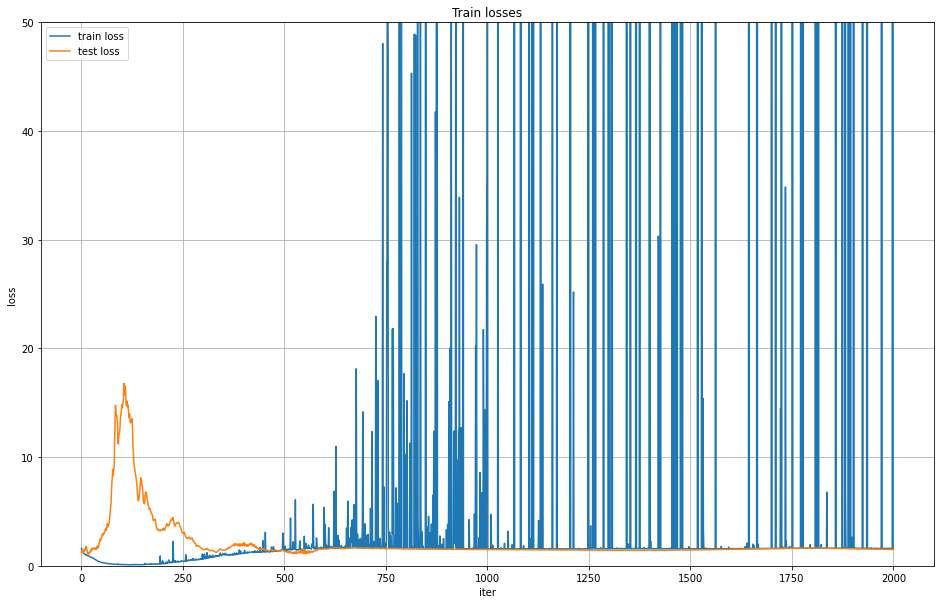

In [74]:
criterion = get_criterion(train_ds, 'ce', device, gamma=2.0)
model = DNNNet().to(device)
#model = CNN_blstm().to(device)
#model = torch.load('models/it3/dnn.e3200.zero_train_loss.ac54.86.pt')
model, tl, vl = train_per_chunk(model, 
                        train_dl, dev_dl,  # egs_list=['028_2016-04-06_Nottingham']
                        epochs=2000, 
                        lr=2e-6,
                        weight_decay=2e-6, 
                        gamma=1,
                        device=device, 
                        criterion=criterion)
torch.save(model, 'models/it3/dnn.2.tmp.pt')
# train= val=0.01172. btz=40, epochs=60, lr=1e-4
# train= val=0.01155. btz=128, epochs=60, lr=1e-4
# train= val=. btz=128, epochs=60, lr=1e-3
# train= val=. btz=128, epochs=60, lr=1e-5
# mse^2 train= val=0.01417. btz=128, epochs=60, lr=1e-3


In [138]:
#torch.save(model, 'models/it3/dnn.e5200.zero_train_loss.ac55.81.pt')

  0%|          | 0/2000 [00:00<?, ?it/s]

Best val loss 15.66691208969463
Best val loss 15.656815853985874
Best val loss 15.57582362131639
Best val loss 15.500522602688182
Best val loss 15.437335187738592
Best val loss 15.383873408490961
Best val loss 15.340431722727688
Best val loss 15.304200584238226
Best val loss 15.272568572651256
Best val loss 15.246813839132136
Best val loss 15.227930296551097
Best val loss 15.206252477385782
Best val loss 15.183476653966038
Best val loss 15.141975272785533
Best val loss 15.10374501618472
Best val loss 15.07038245417855
Best val loss 14.998072981834412
Best val loss 14.853084282441573
Best val loss 14.734058065847917
Best val loss 14.630516724152999
Best val loss 14.498594685034318
Best val loss 14.3588228225708
Best val loss 14.231063225052573
Best val loss 14.114573348652232
Best val loss 13.99814515764063
Best val loss 13.840001062913375
Best val loss 13.682048320770264
Best val loss 13.535261912779374
Best val loss 13.401271679184653
Best val loss 13.276043989441611
Best val loss 13.

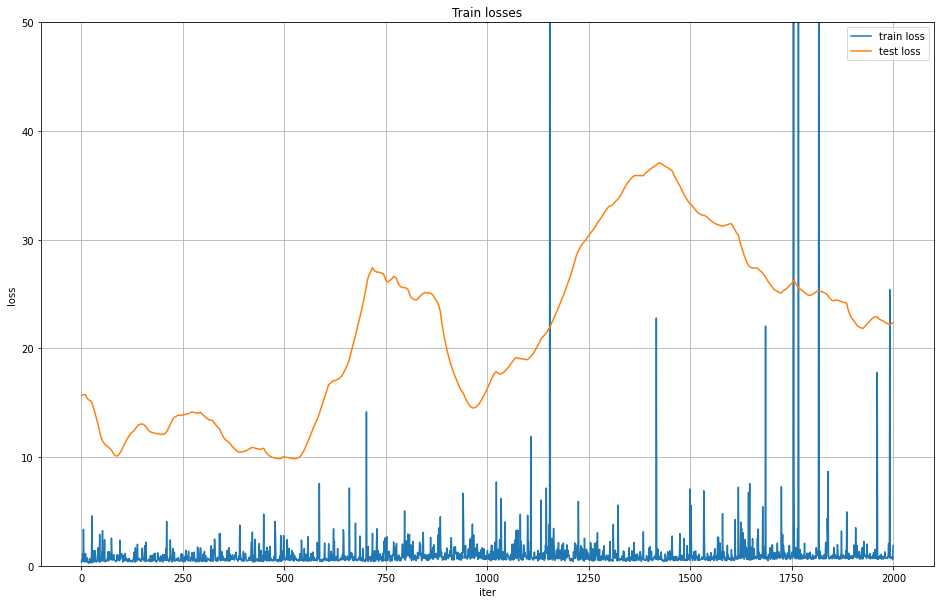

In [134]:
model, tl, vl = train_per_chunk(model, 
                        train_dl, dev_dl,  # egs_list=['028_2016-04-06_Nottingham']
                        epochs=2000, 
                        lr=1e-6,
                        weight_decay=2e-6, 
                        gamma=1,
                        device=device, 
                        criterion=criterion)

In [113]:
# criterion = get_criterion(train_cls_ds, 'focal', device)
# model = EfficientNetASR('b1').to(device)
# #model = CNN_blstm().to(device)
# model = train_per_chunk(model, 
#                         train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
#                         epochs=200, 
#                         lr=1e-4,
#                         weight_decay=1e-6, 
#                         gamma=1,
#                         device=device, 
#                         criterion=criterion)
# torch.save(model, 'models/it2/effnet.focal.pt')

In [352]:
#model = torch.load('models/model.best.pt')

In [75]:
#criterion = get_criterion(train_ds, 'ce', device, gamma=2.0)

loss, cr, conf = eval_cls(model, train_dl, device=device, criterion=criterion)
print("!!!TRAIN!!!")
print(f'{loss=}')
print(cr)
print(conf)

!!!TRAIN!!!
loss=1.5745960665276766
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00       642
          l2       0.00      0.00      0.00      4458
          l3       0.00      0.00      0.00     19771
          l4       0.40      1.00      0.57     18457
          l5       0.00      0.00      0.00      2924

    accuracy                           0.40     46252
   macro avg       0.08      0.20      0.11     46252
weighted avg       0.16      0.40      0.23     46252

[[    0     0     0   642     0]
 [    0     0     0  4458     0]
 [    0     0     0 19771     0]
 [    0     0     0 18457     0]
 [    0     0     0  2924     0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [76]:
loss, cr, conf = eval_cls(model, dev_dl, device=device, criterion=criterion)
print(f'{loss=}')
print(cr)
print(conf)

loss=1.4988842075339919
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00        81
          l2       0.00      0.00      0.00       697
          l3       0.00      0.00      0.00      6361
          l4       0.32      1.00      0.48      4835
          l5       0.00      0.00      0.00      3294

    accuracy                           0.32     15268
   macro avg       0.06      0.20      0.10     15268
weighted avg       0.10      0.32      0.15     15268

[[   0    0    0   81    0]
 [   0    0    0  697    0]
 [   0    0    0 6361    0]
 [   0    0    0 4835    0]
 [   0    0    0 3294    0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [77]:
loss, cr, conf = eval_cls(model, 
                          make_sorted_dataloader(data['English']['dev'],  batch_size=btz, min_sample_len=0),
                          device=device, 
                          criterion=criterion)
print(f'{loss=}')
print(cr)
print(conf)

Dataloader min_sample_len=0
SortedSampler remove 0 (675 -> 675)
loss=1.7723961526697332
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         6
          l2       0.00      0.00      0.00         5
          l3       0.00      0.00      0.00       113
          l4       0.57      1.00      0.72       383
          l5       0.00      0.00      0.00       168

    accuracy                           0.57       675
   macro avg       0.11      0.20      0.14       675
weighted avg       0.32      0.57      0.41       675

[[  0   0   0   6   0]
 [  0   0   0   5   0]
 [  0   0   0 113   0]
 [  0   0   0 383   0]
 [  0   0   0 168   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [ ]:
# loss, cr, conf = eval_cls(model, test_dl, device=device, criterion=criterion)
# print(f'{loss=}')
# print(cr)
# print(conf)

In [142]:

model = torch.load('models/model.best.pt')
loss, cr, conf = eval_cls(model, test_dl, device=device,criterion=criterion)
print(f'{loss=}')
print(cr)
print(conf)
# 0.013951944429427385

loss=17.614564776420593
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         5
          l2       0.00      0.00      0.00         4
          l3       0.81      0.85      0.83        93
          l4       0.88      0.92      0.90       229
          l5       0.14      0.06      0.09        16

    accuracy                           0.84       347
   macro avg       0.37      0.37      0.36       347
weighted avg       0.81      0.84      0.82       347

[[  0   0   3   2   0]
 [  1   0   3   0   0]
 [  2   0  79  12   0]
 [  0   0  12 211   6]
 [  0   0   0  15   1]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [17]:
model = torch.load('models/it3/dnn.e2000.zero_train_loss.ac49.85.pt')


In [ ]:
#for idx in random_idxes:
ipd.display(ipd.Audio(item['expert_wav'][0, :25*chk_len*16], rate=16000))